In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI

from tqdm import tqdm

imagespath = 'error_gradation_images'

In [39]:
data = pd.read_csv("../../../datasets/credit.csv")
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate"], inplace=True)
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,default
0,0.006999,38,0,0.302150,5440.0,4,1,0,3,0,0
1,0.704592,63,0,0.471441,8000.0,9,1,0,0,0,0
2,0.063113,57,0,0.068586,5000.0,17,0,0,0,0,0
3,0.368397,68,0,0.296273,6250.0,16,2,0,0,0,0
4,1.000000,34,1,0.000000,3500.0,0,0,0,1,0,0
5,0.051799,63,0,0.770687,4700.0,16,1,0,1,0,0
6,0.648733,40,1,0.402060,6600.0,10,2,0,3,0,0
7,0.767270,33,0,0.338390,5800.0,10,0,0,3,0,0
8,0.190111,27,0,0.164605,3960.0,6,0,0,1,0,0
9,0.139989,65,1,0.258397,6400.0,6,1,0,0,0,0


In [6]:
data["default"].value_counts()

default
0    13626
1     3088
Name: count, dtype: int64

In [234]:
#model.coef_, model.intercept_

In [40]:
def entropy(a):
    vc = a.value_counts()
    vc/=vc.sum()
    return -(vc*np.log(vc)).sum()

In [41]:
def discretize(data, variables, icat, icont, contdiscstrategy="kmeans", n_bins=3):
    transformers_data = dict()
    
    if icat is None: # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy), 
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None: # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"), 
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
        make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icat]), OrdinalEncoder(categories="auto")),
        make_pipeline(FunctionTransformer(lambda x: x.loc[:, icont]), KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy))
    ),
        FunctionTransformer(lambda x: x.astype("int")))
    
    
    pipeline.fit(data)
    encoded_data = pd.DataFrame(pipeline.transform(data), columns=data.columns if icat is None or icont is None\
                                                                                        else data.columns[icat+icont])
    encoded_data = encoded_data[variables] # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь

    for feat in encoded_data.columns:
        if entropy(encoded_data[feat]) < 0.5:
            print(f"Warning: feature {feat} has practically degenerate states and low entropy")
    transformers_data["transformer"] = pipeline
    
    if icat is None:
        transformers_data["cont_features"]       = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_
        
    elif icont is None:
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_
        
    else:
        transformers_data["cont_features"]           = list(pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"]     = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].bin_edges_
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_
    
    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

#disc_data, pipeline_data = discretize(data, variables, icat=None, icont=[0, 1])


In [42]:
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [43]:
for feat in features:
    print(f"{feat}: entropy = {entropy(data_disc[feat]): .3f}, {list(data_disc[feat].value_counts())}")

DebtRatio: entropy =  0.005, [16705, 7, 2]
MonthlyIncome: entropy =  0.496, [13557, 3122, 35]
NumberOfDependents: entropy =  0.703, [12026, 4064, 624]
NumberOfOpenCreditLinesAndLoans: entropy =  0.892, [9438, 5945, 1331]
NumberOfTime3059DaysPastDueNotWorse: entropy =  0.034, [16625, 86, 3]
NumberOfTime6089DaysPastDueNotWorse: entropy =  0.034, [16625, 86, 3]
NumberRealEstateLoansOrLines: entropy =  0.292, [15392, 1259, 63]
RevolvingUtilizationOfUnsecuredLines: entropy =  0.006, [16702, 11, 1]
SeriousDlqin2yrs: entropy =  0.693, [8357, 8357]
age: entropy =  1.059, [6925, 6326, 3463]


In [6]:
#data = data[data["height"]<0.26]
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [44]:
model = GradientBoostingClassifier(n_estimators=50)
#model = LogisticRegression()
model.fit(data[features], data[target])

GradientBoostingClassifier(n_estimators=50)

In [45]:
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data[target]+(probs)*(1-data[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,inconf_error
0,0.006999,38,0,0.302150,5440.0,4,1,0,3,0,0.024076
1,0.704592,63,0,0.471441,8000.0,9,1,0,0,0,0.022329
2,0.063113,57,0,0.068586,5000.0,17,0,0,0,0,0.022943
3,0.368397,68,0,0.296273,6250.0,16,2,0,0,0,0.020259
4,1.000000,34,1,0.000000,3500.0,0,0,0,1,0,0.373854


In [46]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime3059DaysPastDueNotWorse,NumberOfTime6089DaysPastDueNotWorse,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age,inconf_error
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
16709,0,0,1,0,0,0,0,0,1,1,1
16710,0,0,0,1,0,0,1,0,1,0,1
16711,0,0,0,0,0,0,0,0,1,0,2
16712,0,0,2,0,0,0,0,0,1,1,1


In [47]:
pipeline_data["cont_features"]

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime3059DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime6089DaysPastDueNotWorse',
 'NumberOfDependents',
 'SeriousDlqin2yrs',
 'inconf_error']

In [21]:
pipeline_data["cont_features_edges"]

array([array([    0.        ,  2026.4541447 , 13026.04545455, 22000.        ]),
       array([ 21.        ,  43.15140091,  60.21798055, 101.        ]),
       array([ 0.        , 48.29596992, 97.        , 98.        ]),
       array([    0.        ,  7285.57901154, 34831.05357143, 61106.5       ]),
       array([     0.        ,   8636.59719911,  46634.60738363, 250000.        ]),
       array([ 0.        ,  8.22584063, 16.11523842, 57.        ]),
       array([ 0.        ,  2.23363722,  7.114553  , 29.        ]),
       array([ 0.        , 48.10700752, 97.        , 98.        ]),
       array([0.        , 1.31734046, 3.35315402, 8.        ]),
       array([0. , 0.5, 1. ]),
       array([0.01685294, 0.23222846, 0.56998845, 0.98165683])],
      dtype=object)

In [48]:
current_error = data_errors["inconf_error"].sum()/n
current_error

0.2066426265935197

In [18]:
disc_data["inconf_error"].value_counts()

inconf_error
0    11345
1     3624
2     1745
Name: count, dtype: int64

In [49]:
v = pipeline_data["cont_features_edges"]
for j in [3, 4, 2, 7, 6, 0]:
    v[j] = [v[j][0], (v[j][0]+v[j][1])/2, v[j][1], v[j][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [50]:
data__ = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=disc_data.columns)
data__

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime3059DaysPastDueNotWorse,NumberOfTime6089DaysPastDueNotWorse,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age,inconf_error
0,0,0,0,0,1,0,0,0,1,0,0
1,0,2,0,0,1,1,0,0,0,0,0
2,0,1,0,0,1,2,0,0,0,0,0
3,0,2,0,0,1,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
16709,0,1,0,0,0,0,0,0,1,1,1
16710,0,0,0,0,1,1,2,0,0,1,1
16711,0,0,0,0,0,0,0,0,0,1,2
16712,0,1,0,0,1,0,0,0,2,1,1


In [51]:
for feat in features:
    print(f"{feat}: entropy = {entropy(data__[feat]): .3f}, {list(data__[feat].value_counts())}")

DebtRatio: entropy =  0.008, [16699, 12, 3]
MonthlyIncome: entropy =  1.059, [6925, 6326, 3463]
NumberOfDependents: entropy =  0.033, [16625, 89]
NumberOfOpenCreditLinesAndLoans: entropy =  0.011, [16691, 14, 9]
NumberOfTime3059DaysPastDueNotWorse: entropy =  1.047, [6956, 6601, 3157]
NumberOfTime6089DaysPastDueNotWorse: entropy =  0.892, [9438, 5945, 1331]
NumberRealEstateLoansOrLines: entropy =  0.766, [11945, 3447, 1322]
RevolvingUtilizationOfUnsecuredLines: entropy =  0.033, [16625, 89]
SeriousDlqin2yrs: entropy =  0.703, [12026, 4064, 624]
age: entropy =  0.693, [8357, 8357]


In [53]:
disc_data = data__

In [52]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [54]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 2,
 'age': 2,
 'NumberOfTime3059DaysPastDueNotWorse': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 3,
 'NumberOfTime6089DaysPastDueNotWorse': 3,
 'NumberOfDependents': 2,
 'SeriousDlqin2yrs': 3,
 'inconf_error': 3}

In [10]:
from bamt.networks.base import STORAGE

In [55]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [56]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [57]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,DebtRatio,Discrete,disc,[],[]
1,NumberOfTime6089DaysPastDueNotWorse,Discrete,disc,[],[]
2,NumberRealEstateLoansOrLines,Discrete,disc,[NumberOfTime6089DaysPastDueNotWorse],[disc]
3,NumberOfTime3059DaysPastDueNotWorse,Discrete,disc,"[NumberOfTime6089DaysPastDueNotWorse, NumberRe...","[disc, disc]"
4,MonthlyIncome,Discrete,disc,"[NumberOfTime3059DaysPastDueNotWorse, NumberOf...","[disc, disc]"
5,NumberOfOpenCreditLinesAndLoans,Discrete,disc,[NumberOfTime3059DaysPastDueNotWorse],[disc]
6,age,Discrete,disc,"[MonthlyIncome, NumberOfTime3059DaysPastDueNot...","[disc, disc]"
7,SeriousDlqin2yrs,Discrete,disc,"[MonthlyIncome, NumberOfTime3059DaysPastDueNot...","[disc, disc]"
8,RevolvingUtilizationOfUnsecuredLines,Discrete,disc,"[NumberOfTime3059DaysPastDueNotWorse, age]","[disc, disc]"
9,NumberOfDependents,Discrete,disc,[RevolvingUtilizationOfUnsecuredLines],[disc]


In [58]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [59]:
bn.distributions

{'DebtRatio': {'cprob': [0.9991025487615173,
   0.00017949024769654183,
   0.0007179609907861673],
  'vals': ['0', '1', '2']},
 'NumberOfTime6089DaysPastDueNotWorse': {'cprob': [0.5646763192533206,
   0.35568984085198035,
   0.07963383989469905],
  'vals': ['0', '1', '2']},
 'NumberRealEstateLoansOrLines': {'cprob': {"['0']": [0.8531468531468531,
    0.12555626191989827,
    0.02129688493324857],
   "['1']": [0.5658536585365853, 0.3069806560134567, 0.12716568544995796],
   "['2']": [0.39744552967693464, 0.32832456799398946, 0.2742299023290759]},
  'vals': ['0', '1', '2']},
 'NumberOfTime3059DaysPastDueNotWorse': {'cprob': {"['0', '0']": [0.5623447590660705,
    0.34115747640337807,
    0.09649776453055142],
   "['0', '1']": [0.2742616033755274, 0.4759493670886076, 0.249789029535865],
   "['0', '2']": [0.17412935323383086, 0.4527363184079602, 0.373134328358209],
   "['1', '0']": [0.38406658739595717,
    0.43727705112960763,
    0.1786563614744352],
   "['1', '1']": [0.21753424657534245

In [60]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

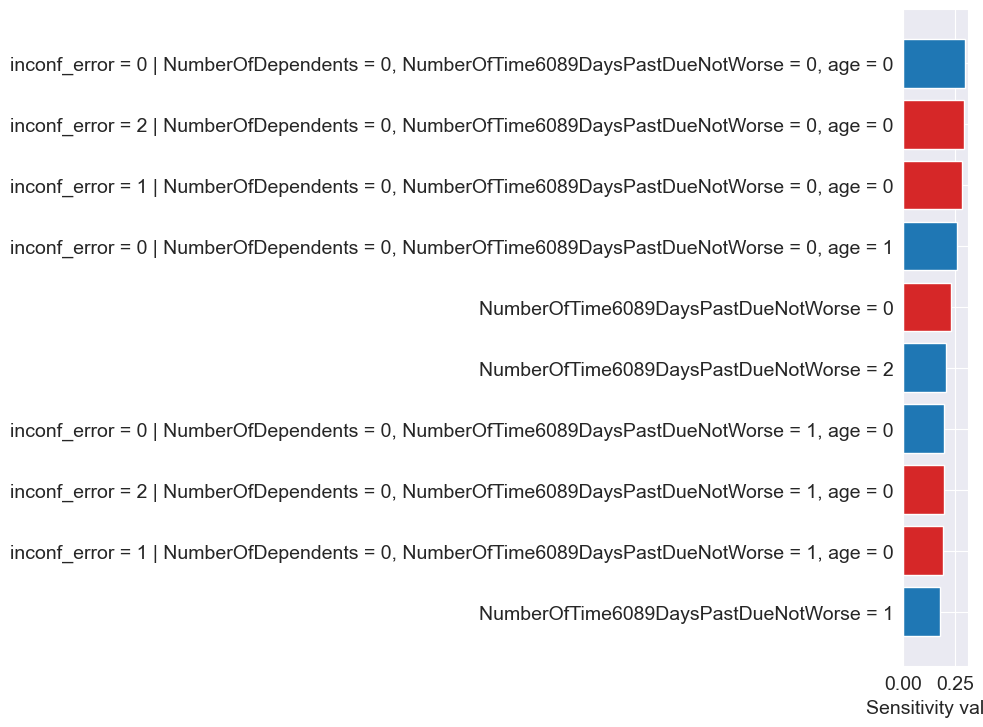

In [61]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 0}, nbars=10)

<Figure size 640x480 with 0 Axes>

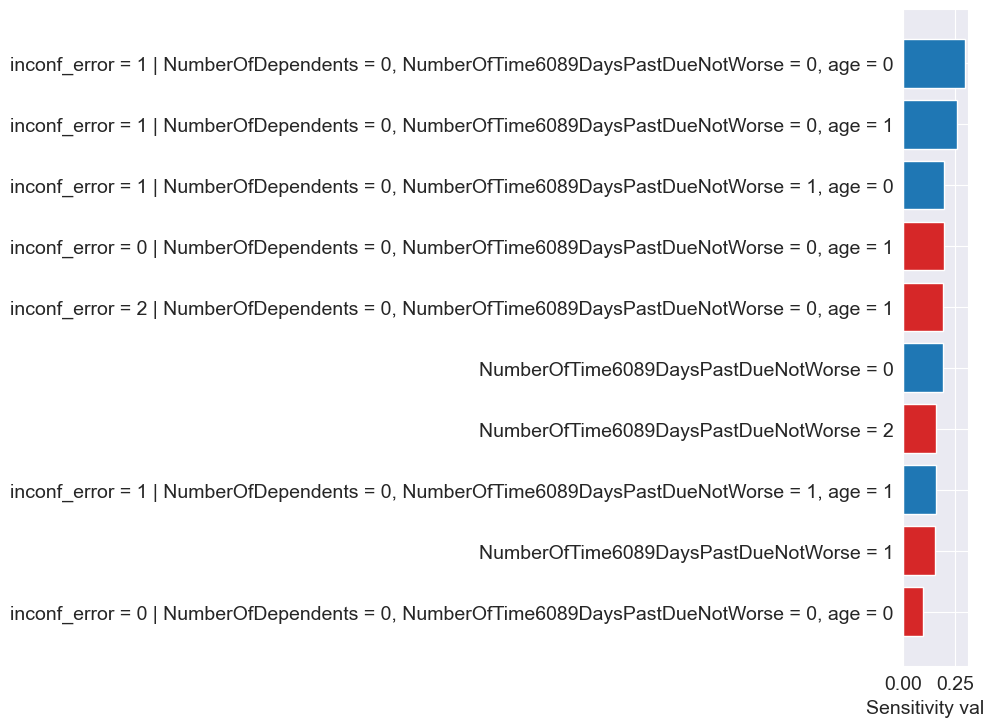

In [62]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 1}, nbars=10)

<Figure size 640x480 with 0 Axes>

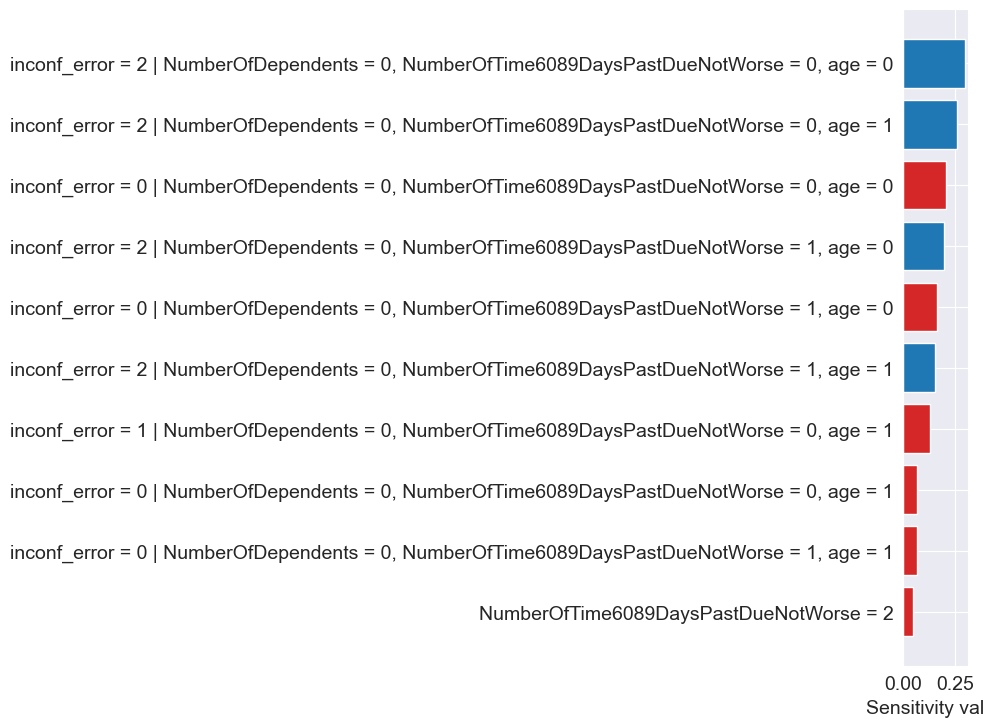

In [63]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого УФ-индекса (здесь 1 маскимальный) и среднего давления

In [64]:
current_error

0.2066426265935197

In [69]:
from copy import copy

# BicScore boosting: diameter = High, shell_weight = Mid
# K2Score boosting: нет рекомендаций
# logreg: [S_weight, diameter, rings, shell_weight, viscera_weight] = [0, 1, 0, 0, 0]

In [65]:
from sklearn.metrics import log_loss, roc_auc_score

In [66]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

In [76]:
#dfeat = ["length", "shell_weight"]
#dcat = [2, 1]
dfeat = ["age", "NumberOfDependents"]
dcat = [0, 0]
bn = n
def bootstrap_sampling(dfeat, dcat, metrics_list, trials=1000, alpha=0, incl_random_removal=False):
    
    diffs = list()
    metrics_before, metrics_after = [list() for _ in range(len(metrics_list))], [list() for _ in range(len(metrics_list))]
    metrics_random = [list() for _ in range(len(metrics_list))]
    n_dropped = list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        indexes = np.random.choice(data.index, size=bn)
        bsample = data.loc[indexes]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(data_errors.loc[indexes]), columns=data_errors.columns)
        
        mask = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
        
        X1, y1 = bsample[features], bsample[target]
        model1, model2 = copy(model), copy(model)
        model1.fit(X1, y1)
        y1_pred = model1.predict(X1)
        indexes_to_drop = np.random.choice(bsample[mask].index, size=int(np.floor(bsample[mask].shape[0]*(1-alpha))), replace=False)
        
        new_bsample = bsample.drop(index=indexes_to_drop)
        
        
        X2, y2 = new_bsample[features], new_bsample[target]
        
        model2.fit(X2, y2)
        
        y2_pred = model2.predict(X2)
        for k, metric in enumerate(metrics_list):
            metrics_before[k].append(metric(y1, y1_pred))
            metrics_after[k].append(metric(y2, y2_pred))
        
        if incl_random_removal:
            random_bsample = bsample.sample(indexes_to_drop.shape[0])
            X3, y3 = random_bsample[features], random_bsample[target]
            model3 = copy(model)
            model3.fit(X3, y3)
            y3_pred = model3.predict(X3)
            for k, metric in enumerate(metrics_list):
                metrics_random[k].append(metric(y3, y3_pred))
            
            
        diffs.append(metrics_before[0][-1] - metrics_after[0][-1])
        n_dropped.append(indexes_to_drop.shape[0])
    
    if not incl_random_removal:
        return metrics_before, metrics_after, diffs, sum(n_dropped)/trials
    else:
        return metrics_before, metrics_after, diffs, sum(n_dropped)/trials, metrics_random

In [77]:
data.shape

(16714, 11)

In [80]:
np.random.seed(42)
metrics_before, metrics_after, diffs, mean_dropped, metrics_r = bootstrap_sampling(dfeat, dcat, [inconfidence_score, 
                                                                                                 log_loss,
                                                                                                 roc_auc_score], trials=150,alpha=0.5, incl_random_removal=True)

100%|██████████| 150/150 [10:08<00:00,  4.06s/it]


In [81]:
mean_dropped, mean_dropped/n

(7100.826666666667, 0.4248430457500698)

In [82]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500, alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

TypeError: bootstrap_sampling() missing 1 required positional argument: 'metrics_list'

In [26]:
2505/n

0.8835978835978836

In [23]:
percentage_changes[0]

-79.64020676794598

Text(0, 0.5, 'Mean score difference')

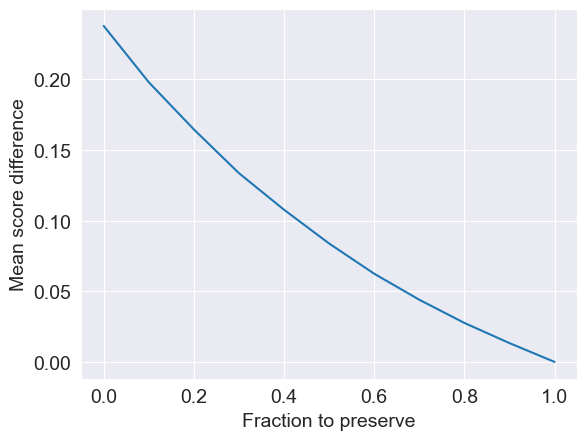

In [24]:
plt.plot(alphas, mean_differences)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")

Text(0, 0.5, 'Mean score percentage change')

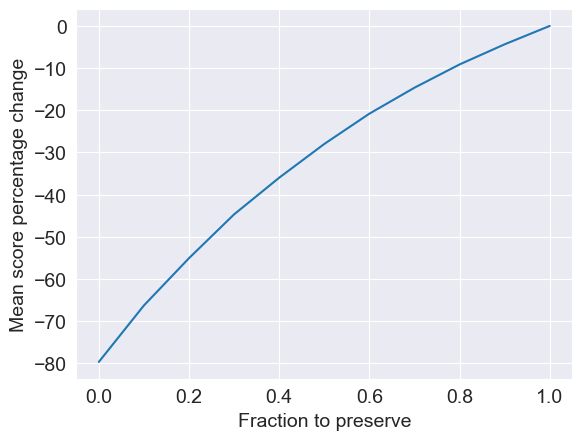

In [25]:
plt.plot(alphas, percentage_changes)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score percentage change")

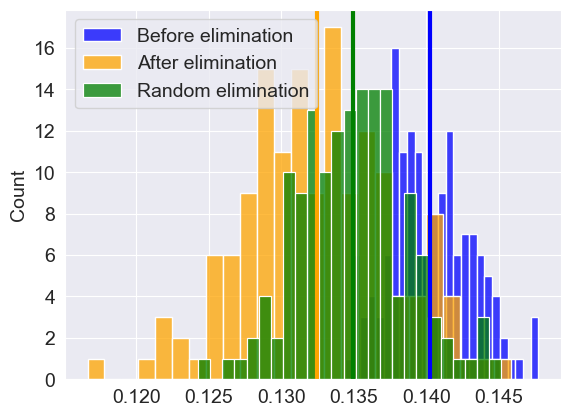

In [83]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.legend()

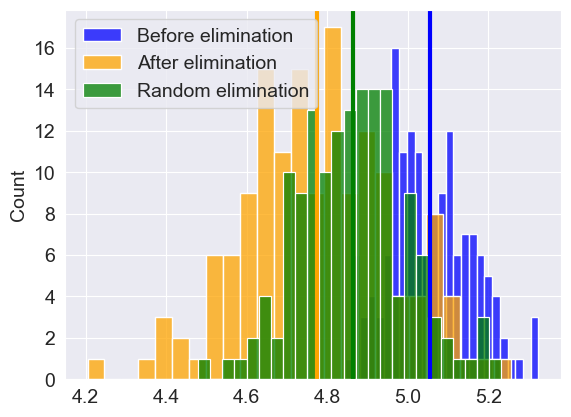

In [84]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.legend()

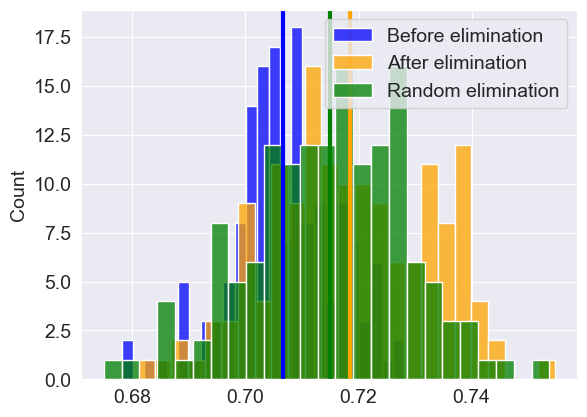

In [85]:
sns.histplot(metrics_before[2], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[2], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[2], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[2]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[2]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[2]), color="green", linewidth=3)
plt.legend()

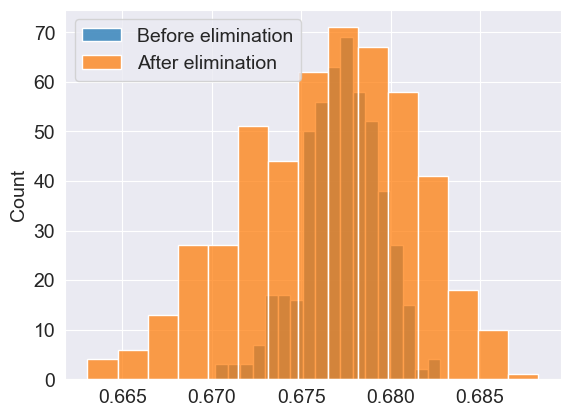

In [147]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

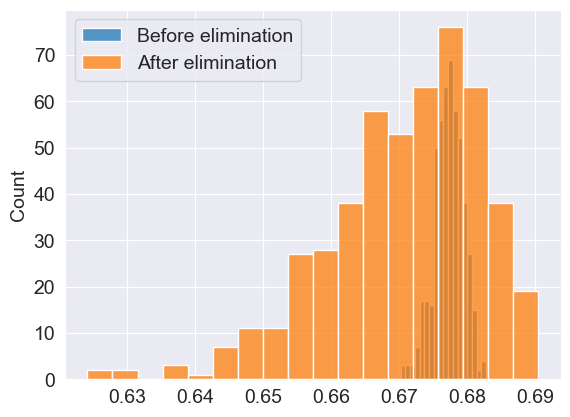

In [151]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

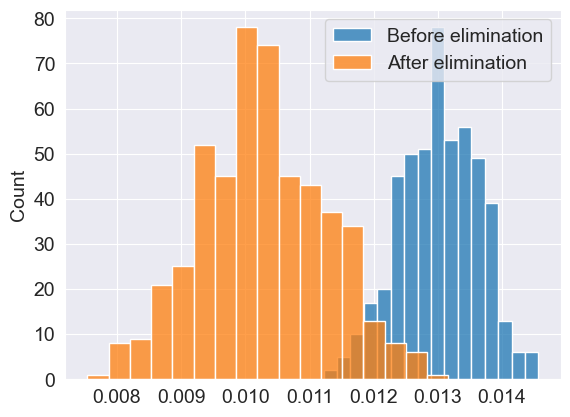

In [75]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [40]:
from scipy.stats import ttest_rel

In [220]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=nan, pvalue=nan, df=nan)

In [254]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=5.389314443207421, pvalue=1.0925112258579377e-07, df=499)

In [86]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,MonthlyIncome_1,MonthlyIncome_2,NumberOfDependents_0,NumberOfDependents_2,NumberOfOpenCreditLinesAndLoans_0,NumberOfOpenCreditLinesAndLoans_1,...,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_2,SeriousDlqin2yrs_0,SeriousDlqin2yrs_1,SeriousDlqin2yrs_2,age_0,age_1,inconf_error_0,inconf_error_1,inconf_error_2
0,1,0,0,1,0,0,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
1,1,0,0,0,0,1,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
2,1,0,0,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
3,1,0,0,0,0,1,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
4,1,0,0,1,0,0,1,0,1,0,...,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,1,0,0,0,1,0,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
16710,1,0,0,1,0,0,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0
16711,1,0,0,1,0,0,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
16712,1,0,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0


In [87]:
from itertools import product

In [88]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "sq_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "sq_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2023-11-16 12:15:29,949 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,950 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,951 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,952 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,953 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,954 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,955 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,956 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,956 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-16 12:15:29,957 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [89]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,DebtRatio_0,Discrete,disc,[],[]
1,DebtRatio_1,Discrete,disc,[],[]
2,DebtRatio_2,Discrete,disc,[],[]
3,NumberRealEstateLoansOrLines_1,Discrete,disc,[],[]
4,NumberRealEstateLoansOrLines_2,Discrete,disc,[],[]
5,NumberOfTime6089DaysPastDueNotWorse_0,Discrete,disc,"[NumberRealEstateLoansOrLines_1, NumberRealEst...","[disc, disc]"
6,NumberOfTime3059DaysPastDueNotWorse_0,Discrete,disc,"[NumberOfTime6089DaysPastDueNotWorse_0, Number...","[disc, disc, disc]"
7,MonthlyIncome_1,Discrete,disc,"[NumberOfTime3059DaysPastDueNotWorse_0, Number...","[disc, disc]"
8,NumberOfOpenCreditLinesAndLoans_2,Discrete,disc,[NumberOfTime3059DaysPastDueNotWorse_0],[disc]
9,NumberOfTime3059DaysPastDueNotWorse_1,Discrete,disc,"[MonthlyIncome_1, NumberOfTime6089DaysPastDueN...","[disc, disc, disc]"



# k2score boosting: нет рекомендаций
# regression : [Tsurf_mean_0, pressure_2]

In [92]:
dfeat = ["NumberOfTime6089DaysPastDueNotWorse", "age"]
dcat = [0, 1]
np.random.seed(42)
metrics_before, metrics_after, diffs, mean_dropped, metrics_r = bootstrap_sampling(dfeat, dcat, [inconfidence_score, 
                                                                                                 log_loss,
                                                                                                 roc_auc_score], trials=150,alpha=0.5, incl_random_removal=True)

100%|██████████| 150/150 [09:06<00:00,  3.65s/it]


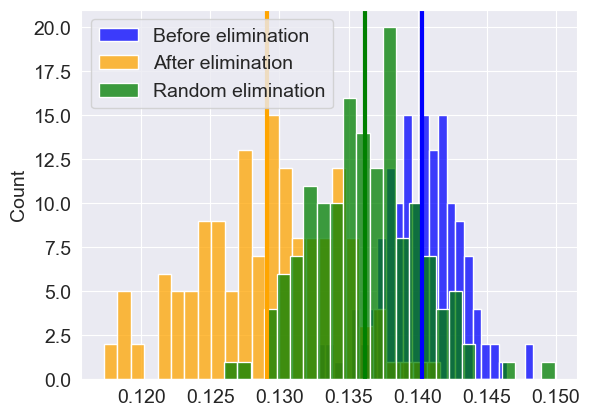

In [93]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.legend()

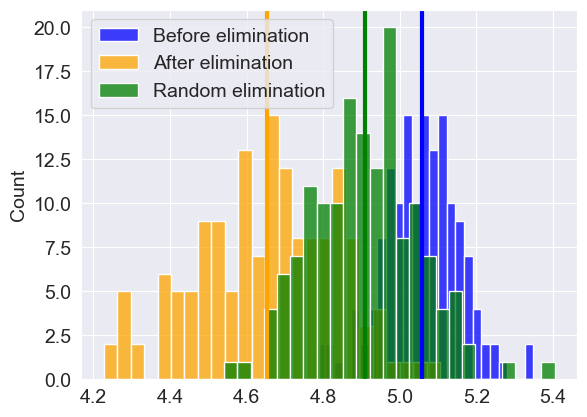

In [94]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.legend()

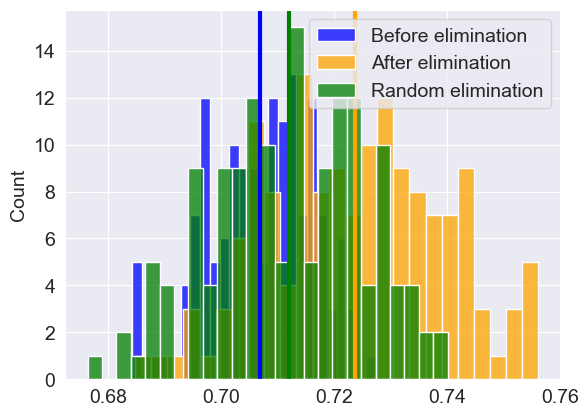

In [95]:
sns.histplot(metrics_before[2], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[2], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[2], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[2]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[2]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[2]), color="green", linewidth=3)
plt.legend()

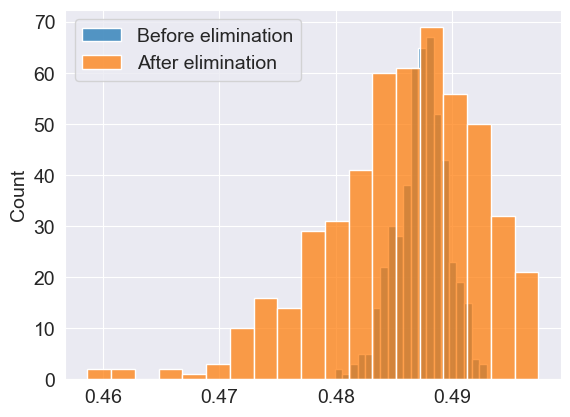

In [261]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [229]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=45.363657433495675, pvalue=3.570673536410195e-179, df=499)

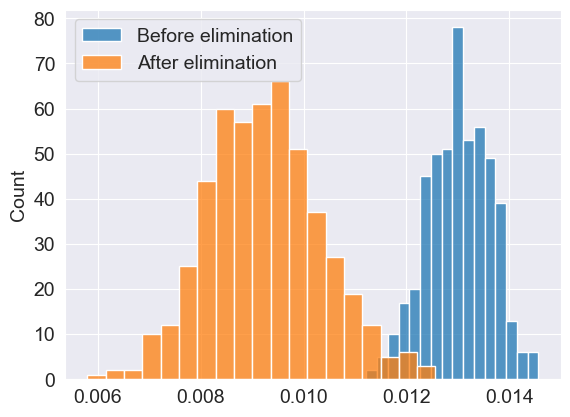

In [81]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [37]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=3.5513027688261474, pvalue=0.0005886470203057337)

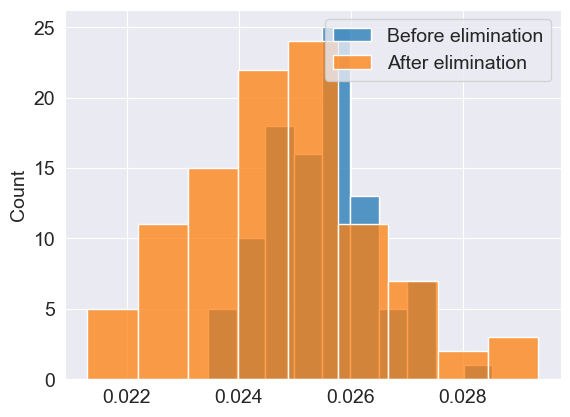

In [39]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [40]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=4.5674716964522615, pvalue=1.4238634976675129e-05)

In [41]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [42]:
disc_data_onehot

,Tsurf_mean_0,Tsurf_mean_1,Tsurf_mean_2,Water_mean_0,Water_mean_1,Water_mean_2,Speed_mean_0,Speed_mean_1,Speed_mean_2,totalSnow_cm_0,...,humidity_2,precipMM_0,precipMM_1,precipMM_2,pressure_0,pressure_1,pressure_2,sq_error_0,sq_error_1,sq_error_2
0,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0
3,0,0,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
996,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
997,0,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
998,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [43]:
gbn = DiscreteBNGI(imagespath)

In [44]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

KeyError: 'Tsurf_mean_0'

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")